[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brightbandtech/nnja-ai/blob/main/example_notebooks/adpupa_profile_example.ipynb)

In [1]:
# Uncomment the following line to install the package
#!pip install git+https://github.com/brightbandtech/nnja-ai.git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Plotting profiles with the ADPUPA data

This notebook shows some of the nuances of the APDUPA upper-air rawinsonda data and examples of how to quickly load a useful subset of this data.



The ADPUPA upper-air data primary data packet is found within the UARLV field. This column is present in the parquet files, and structured with nested structs like so:
```
├──{UARLV}          |  RADIOSONDE REPORT LEVEL DATA           
│  ├──VSIG          |  VERTICAL SOUNDING SIGNIFICANCE         
│  ├──QMPR          |  SDMEDIT QUALITY MARK FOR PRESSURE      
│  ├──PRLC          |  PRESSURE                               
│  ├──QMGP          |  SDMEDIT QUALITY MARK FOR GEOPOTENTIAL  
│  ├──<UAGP07>      |  RADIOSONDE CLASS 7 GEOPOTENTIAL DATA   
│  │  └──GP07       |  GEOPOTENTIAL                           
│  ├──<UAGP10>      |  RADIOSONDE CLASS 10 GEOPOTENTIAL DATA  
│  │  └──GP10       |  GEOPOTENTIAL                           
│  ├──<UATMP>       |  RADIOSONDE TEMPERATURE DATA            
│  │  ├──QMAT       |  SDMEDIT QUALITY MARK FOR TEMPERATURE   
│  │  ├──TMDB       |  TEMPERATURE/DRY BULB TEMPERATURE       
│  │  ├──QMDD       |  SDMEDIT QUALITY MARK FOR MOISTURE      
│  │  └──TMDP       |  DEW POINT TEMPERATURE                  
│  ├──<UAWND>       |  RADIOSONDE WIND DATA                   
│  │  ├──QMWN       |  SDMEDIT QUALITY MARK FOR WIND          
│  │  ├──WDIR       |  WIND DIRECTION                         
│  │  └──WSPD       |  WIND SPEED                             
│  └──<UAWSH>       |  RADIOSONDE WIND SHEAR DATA             
│     ├──AWSB       |  ABSOLUTE WIND SHEAR IN 1 KM LAYER BELOW
│     └──AWSA       |  ABSOLUTE WIND SHEAR IN 1 KM LAYER ABOVE
```
More in-depth BUFR nomenclature can be found online, but the important bits here are that `{}` brackets indicate an "8-bit delayed replication", i.e. "this is an array of up to 255 elements", and `<>` brackets indicate a single delayed replication, i.e. "this field may or may not be present". 

Interpeting the above structure, for each message subset (i.e. parquet row), `UARLV` is an array of structs with some keys (e.g. `VSIG`) that are always present, and some number of nested structs that may or may not be present (e.g. `UAGP07`). Each array element in `UARLV` corresponds to a set of observations at a specific pressure level. Additionally, VSIG is a 7-bit [flag](https://www.nco.ncep.noaa.gov/sib/jeff/CodeFlag_0_STDv31_LOC7.html#008001) that indicates what type of pressure level this entry corresponds to. The main types are [standard levels/mandatory levels](https://glossary.ametsoc.org/wiki/Mandatory_level), indicated by a flag value of 32 (2nd-most-significant bit set), and [significant levels](https://glossary.ametsoc.org/wiki/Significant_level) for either temperature or wind. The mandatory levels are always fixed (21 in total), while there can be an arbitrary number of significant levels. 

As a result, the mandatory levels have been factored out of UARLV for convenient access without needing to load the entire UARLV structure.


In [ ]:
# loading adpupa data from nnja-ai
from nnja import DataCatalog

catalog = DataCatalog(mirror="gcp_brightband")
adpupa_ds = catalog["conv-adpupa-NC002001"]
ds = adpupa_ds.sel(time="2021-01-01").load_dataset(backend="pandas")

Loading manifest for dataset 'conv-adpupa-NC002001'...


/Users/hans/code/nnja-ai/src/nnja/dataset.py:339: UserWarning: Naive datetime 2021-01-01 00:00:00 assumed to be in UTC
  warnings.warn(f"Naive datetime {dt} assumed to be in UTC", UserWarning)


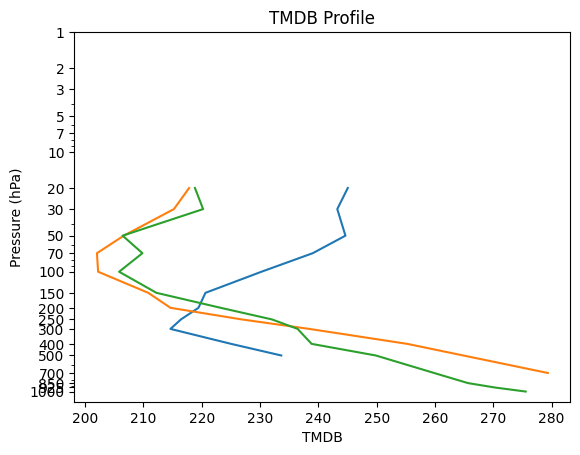

In [ ]:
def plot_mandatory_profile_simple(ds: pd.Series, variable: str, ax=None):
    """
    Plot a profile of a mandatory variable from the ADPUPA data.

    Args:
        ds: A pandas Series object containing the ADPUPA data for a single sounding
        variable: The variable to plot, e.g. 'TMDB' for temperature
        ax: An optional matplotlib Axes object to plot on
    """
    # these would be columns in the full dataset, rows in this series
    relevant_rows = [i for i in ds.index if variable in i]
    # these are now rows with values like 'TMDB_PRLC100', 'TMDB_PRLC200', 'TMDB_PRLC300'
    vals, pressures = [], []
    for i in relevant_rows:
        vals.append(ds[i])
        pressures.append(int(i.split("_")[-1][4:]))
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(vals, pressures, label="mandatory levels")
    ax.set_xlabel(variable)
    ax.set_ylabel("Pressure (hPa)")
    ax.set_title(f"{variable} Profile")

    ax.set_yscale("log")
    ax.invert_yaxis()
    ax.set_yticks(pressures)
    ax.set_yticklabels([f"{i/100:.0f}" for i in pressures])
    return


fig, ax = plt.subplots()
plot_mandatory_profile_simple(ds.iloc[0], "TMDB", ax)
plot_mandatory_profile_simple(ds.iloc[100], "TMDB", ax)
plot_mandatory_profile_simple(ds.iloc[200], "TMDB", ax)


A note on the mandatory level data: because there are a fixed number of mandatory pressure levels, we can flatten this portion of the sounding data to a consistent structure. However, these soundings do still come from balloons that may be launched from high altitude, and may not reach the same height, so each sounding will likely have some null values at the lowest and highest pressure levels, as shown in the plot above. 

We can also trivially plot a map of e.g. all 500 hpa winds, though with the sparseness of the data, it might not be the most interesting:

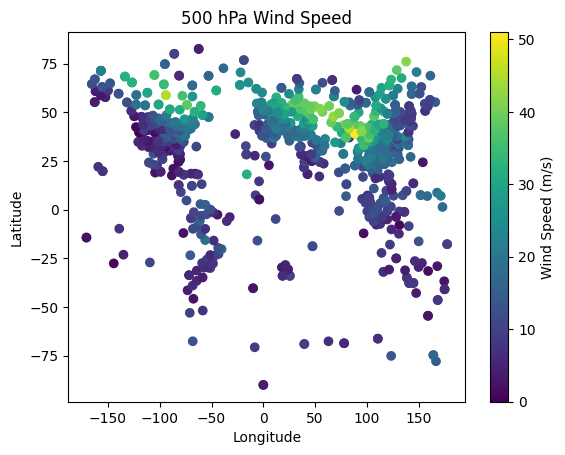

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(ds["LON"], ds["LAT"], c=ds["WSPD_PRLC5000"], cmap="viridis")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("500 hPa Wind Speed")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("Wind Speed (m/s)")


### Getting the full sounding from UARLV

Even though we haven't unpacked the significant level data, we can still dig it out of the UARLV arrays, albeit with a bit more difficulty.

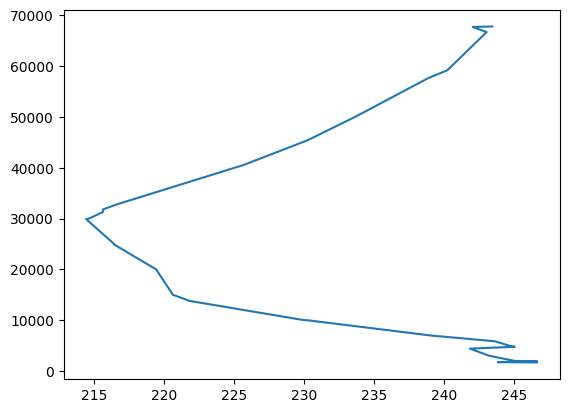

In [ ]:
def get_sounding_from_UARLV(UARLV: np.array) -> pd.DataFrame:
    """
    Unpack the UARLV array into a pandas DataFrame of the individual variables.
    """
    pressures, temperatures, dew_points, wind_directions, wind_speeds = [], [], [], [], []
    for i in UARLV:
        # if pressure is missing, skip
        if i["PRLC"] == 1e11:
            continue
        pressures.append(i["PRLC"])
        temperatures.append(i["UATMP"]["TMDB"])
        dew_points.append(i["UATMP"]["TMDP"])
        wind_directions.append(i["UAWND"]["WDIR"])
        wind_speeds.append(i["UAWND"]["WSPD"])

    # these haven't been filtered for the sentinel missing flag of 1e11
    # we can do that here

    pressures = [None if i == 1e11 else i for i in pressures]
    temperatures = [None if i == 1e11 else i for i in temperatures]
    dew_points = [None if i == 1e11 else i for i in dew_points]
    wind_directions = [None if i == 1e11 else i for i in wind_directions]
    wind_speeds = [None if i == 1e11 else i for i in wind_speeds]

    return (
        pd.DataFrame(
            {
                "pressure": pressures,
                "temperature": temperatures,
                "dew_point": dew_points,
                "wind_direction": wind_directions,
                "wind_speed": wind_speeds,
            }
        )
        .set_index("pressure")
        .sort_index()
    )


def plot_sounding(sounding: pd.DataFrame, variable: str, ax=None):
    """
    Plot a sounding of a variable from the ADPUPA data.
    """
    if ax is None:
        _, ax = plt.subplots()

    # trim out nans for a cleaner plot
    sounding = sounding[sounding[variable].notna()]
    ax.plot(sounding[variable], sounding.index, label="significant levels")


fig, ax = plt.subplots()
sounding = get_sounding_from_UARLV(ds.iloc[0]["UARLV"])
plot_sounding(sounding, "temperature", ax)

Moreover, these are from the same soundings, just at different levels, which we can show by plotting them together:

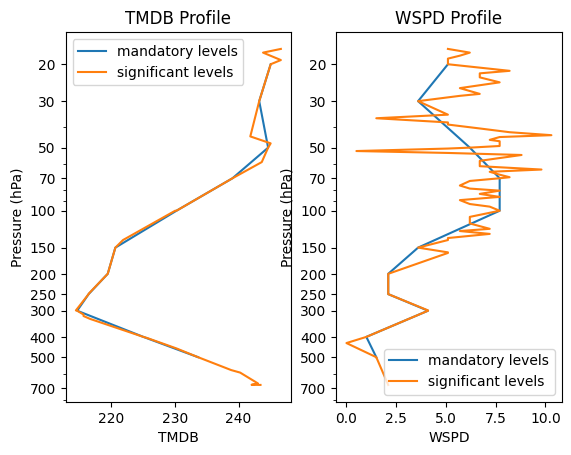

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2)
sample = ds.iloc[0]
sounding = get_sounding_from_UARLV(sample["UARLV"])
plot_mandatory_profile_simple(sample, "TMDB", ax1)
plot_sounding(sounding, "temperature", ax1)
ax1.legend()
plot_mandatory_profile_simple(sample, "WSPD", ax2)
plot_sounding(sounding, "wind_speed", ax2)
ax2.legend()


## Conclusion

Both the original sounding at 'full' resolution as well as a simplified mandatory level-only sounding are available in the NNJA-AI upper-air data, with the latter being 'fast' to access. 